In [2]:
from pathlib import Path
from environment_manager import *
import re
import System
import Grasshopper.Kernel as ghk
from Grasshopper.Kernel import IGH_Component, IGH_Param, GH_Document
from Grasshopper.Kernel import GH_DocumentIO

In [3]:
# create the loggers

import logging

def create_named_logger(name, filename):
    # Create a logger with the specified name
    logger = logging.getLogger(name)

    # Set the log level to INFO
    logger.setLevel(logging.DEBUG)

    # Create a file handler
    handler = logging.FileHandler(filename, mode='w')

    # Set the level of the handler to INFO
    handler.setLevel(logging.DEBUG)

    # Create a formatter
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

    # Add the formatter to the handler
    handler.setFormatter(formatter)

    # Add the handler to the logger
    logger.addHandler(handler)

    return logger

logging_location = r"C:\Users\jossi\Dropbox\Office_Work\Jos\GH_Graph_Learning\logs"
# Usage

def debug_obj(obj):
    complog.debug("The object is not an IGH_Component or IGH_Param.")
    complog.debug(f"Name: {obj.Name}")
    complog.debug(f"Nickname: {obj.NickName}")  
    complog.debug(f"Guid: {obj.ComponentGuid}")
    complog.debug(f"IGHComponent: {GHComponent_.is_cls(obj, ghk.IGH_Component)}")
    complog.debug(f"IGHParam: {GHComponent_.is_cls(obj, ghk.IGH_Param)}")
    

complog = create_named_logger('components', Path(logging_location) / 'complog.log')
complog.info('Loggging started')

Create the version Environment

In [4]:

name = "240308-initial_test"
env = load_create_environment(name)
gct = GHComponentTable
GHComponentTable.initialise()



Setting environment variables
Copying vanilla components
File copied successfully from C:\Users\jossi\Dropbox\Office_Work\Jos\GH_Graph_Learning\Grasshopper Components\240307-CoreComponents\vanilla_components.csv to ExtractionEnvironments\240308-initial_test\00-VanillaComponents\vanilla_components.csv.
Copying components
Copying gh files


In [5]:


def doc_save(doc):
    ghdio = GH_DocumentIO(doc)
    ghdio.Save()    



def remove_unwanted_items(doc, illegals_dict):
    illegals_set = set([str(v) for v in illegals_dict.values()])
    removables = [obj for obj in doc.Objects if str(obj.ComponentGuid) in illegals_set]
    for obj in removables:
        doc.RemoveObject(obj, True)
    return doc

def doc_save(doc):
    ghdio = GH_DocumentIO(doc)
    ghdio.Save()

def get_component_type(component):
    pattern = r"^(.*?)_OBSOLETE"
    match = re.search(pattern, str(component))
    return match.group(1) if match else None

def create_new_component(component_type):
    replacement_guids = GHComponentTable.get_guid_by_type(component_type)
    if replacement_guids:
        new_component_proxy = GHComponentTable.search_component_by_guid(System.Guid(replacement_guids[0]))
        if new_component_proxy:
            return new_component_proxy.CreateInstance()
    return None

def rewire_connections(old_component, new_component):
    old_component_obj = GHComponent_.convert_cls(old_component, ghk.IGH_Component)
    new_component_obj = GHComponent_.convert_cls(new_component, ghk.IGH_Component)

    if old_component_obj and new_component_obj:
        for input, new_input in zip(old_component_obj.Params.Input, new_component_obj.Params.Input):
            for source in input.Sources:
                new_input.AddSource(source)
        for output, new_output in zip(old_component_obj.Params.Output, new_component_obj.Params.Output):
            for recipient in output.Recipients:
                recipient.AddSource(new_output)

    else:
        old_param_obj = GHComponent_.convert_cls(old_component, ghk.IGH_Param)
        new_param_obj = GHComponent_.convert_cls(new_component, ghk.IGH_Param)

        if old_param_obj and new_param_obj:
            for source in old_param_obj.Sources:
                new_param_obj.AddSource(source)
            for recipient in old_param_obj.Recipients:
                recipient.AddSource(new_param_obj)

        else:
            print(f"Cannot rewire connections. Incompatible component types: {type(old_component)} and {type(new_component)}")

def replace_component(doc, old_component, new_component):
    if new_component:
        new_component.Attributes.Pivot = old_component.Attributes.Pivot
        doc.AddObject(new_component, False)
        rewire_connections(old_component, new_component)
        doc.RemoveObject(old_component, True)
        return True
    return False

def replace_obsolete_components(doc):
    for component in list(doc.Objects):
        if hasattr(component, 'Obsolete') and component.Obsolete:
            component_type = get_component_type(component)
            if component_type:
                new_component = create_new_component(component_type)
                if not replace_component(doc, component, new_component):
                    print(f"Could not replace obsolete component: {component.Name}")
    print("Replacement of obsolete components complete.")
    return doc

def remove_placeholder_components(doc, update=True):
    objects = doc.Objects
    placeholders = []
    for component in doc.Objects:
        a = GHComponentTable.get_guid_to_idx(str(component.ComponentGuid))
        if a is None:
            placeholders.append(component)
    if update:
        ghk.GH_Document.NewSolution(doc, False)

    for placeholder in placeholders:
        doc.RemoveObject(placeholder, False)

    return doc




def preprocess_and_replace(doc, illegals_dict, overwrite=True):
    doc = remove_unwanted_items(doc, illegals_dict)
    doc = replace_obsolete_components(doc)
    doc = remove_placeholder_components(doc)  # Add this line to remove placeholder components

    if overwrite:
        try:
            doc_save(doc)
        except Exception as e:
            new_file_path = file.with_name(file.stem + file.suffix)
            shutil.move(file, error_bin / new_file_path)
            print(f"Error in saving {doc}: {e}")
            print("File moved to error bin.")
            
    print("Preprocessing, replacement, and placeholder removal complete.")
    return doc

In [6]:
class GHNode_:
    def __init__(self, obj: ghk.IGH_DocumentObject):
        self.obj = obj
        self.category = obj.Category
        self.name = obj.Name
        self.id = str(obj.InstanceGuid)
        assert self.id is not None, "The object must have a valid GUID"
        self.position = obj.Attributes.Pivot if hasattr(obj.Attributes, "Pivot") else None
        self.uid = f"{self.category}_{self.name}_{self.id[-5:]}"
        # Assuming global_idx is somehow related to GHComponentTable, which might need instance reference
        self.global_idx = GHComponentTable.component_to_idx(self)  # This requires GHComponentTable method adjustment
        self.graph_id = None

    def get_recipients(self):
        """To be implemented by the subclass"""
        pass

    def __str__(self):
        return f"{self.uid}"

    def __repr__(self):
        return f"<GHNode {self.__str__()}>"

    def log_properties(self):
        log = {
            f"Category: {self.category}, "
            f"Name: {self.name}, "
            f"ID: {self.id[-5:]}, "
            f"Position: {self.position}"
            f"Global: {self.global_idx}"
        }
        # This method seems intended for logging or debugging, consider how it's used and adapt accordingly.

In [7]:
class GHParam_:

    def __init__(self, obj):
        self.obj = obj
        self.parent = GHNode(ghk.IGH_DocumentObject(obj).Attributes.GetTopLevel.DocObject)
        self.name = obj.Name
        self.datamapping = int(obj.DataMapping)  # enumerator 0:none, 1:Flatten, 2:Graft
        self.pkind = obj.Kind  # the kind: floating (top level), input (parameter tied to component as input), output (parameter tied to a component as an output
        self.dataEmitter = obj.IsDataProvider  # boolean stating whether this object is able to emit data
        # self.typ = obj.Type
        self.typname = obj.TypeName  # human-readable descriptor of this parameter
        self.optional = obj.Optional  # gets whether this parameter is optional to the functioning of the component
        # logging.info(f'GHComponent {self.parent.name} Params: {self.log_properties()}')

    @property
    def recipients(self):
        # if there are no recipents to this parameter, return none
        return [rcp for rcp in self.obj.Recipients] if len(self.obj.Recipients) > 0 else None

    @property
    def sources(self):
        # if there are no recipents to this parameter, return none
        return [rcp for rcp in self.obj.Sources] if len(self.obj.Sources) > 0 else None

    @property
    def data(self):
        return self.obj.VolatileData.DataDescription(False, False)

    def log_properties(self):
        properties = (
            f"Name: {self.name}, "
            f"DataMapping: {self.datamapping}, "
            f"Kind: {self.pkind}, "
            f"DataEmitter: {self.dataEmitter}, "
            f"TypeName: {self.typname}, "
            f"Optional: {self.optional}, "
            f"Data: {self.data}, "
        )
        return properties

    def __str__(self):
        repr_obj = ghk.IGH_DocumentObject(self.obj)
        return f"param:{self.name}"

    def __repr__(self):
        return f"<GHParam {self.__str__()}>"

In [8]:
from typing import Union
class GHComponent_(GHNode_):
    """Subclass of GHNode that handles GH components that implement IGH_Component.
    Each GHComponent object should contain a list of input parameter and output parameter objects.
    These parameter objects have access to the sources and recipients of the parameter"""

    def __init__(self, obj):
        super().__init__(obj)
        self.obj: Union[IGH_Component or IGH_Param] = None
        self.iparams = []
        self.oparams = []
        self.recipients = []
        self.iparams_dict = {}
        self.oparams_dict = {}

        # Attempt to initialize parameters
        self.initialize_parameters(obj)
        self.initialize_lookup_dicts()
    
    def initialize_parameters(self, obj):
        if GHComponent_.is_cls(obj, ghk.IGH_Component):
            self.obj = IGH_Component(obj)
            self.iparams = [GHParam_(p) for p in self.obj.Params.Input]
            self.oparams = [GHParam_(p) for p in self.obj.Params.Output]
        
        elif GHComponent_.is_cls(obj, ghk.IGH_Param):
            self.obj = IGH_Param(obj)
            param = GHParam_(self.obj)
            self.iparams = [param]
            self.oparams = [param]
        else:
            debug_obj(obj)
            raise TypeError("The object is not an IGH_Component or IGH_Param.")

    def initialize_lookup_dicts(self):
        self.iparams_dict = {k.name: i for i, k in enumerate(self.iparams)}
        complog.debug(f"{self.name}: iparams dict: {self.iparams_dict}")
        self.oparams_dict = {k.name: i for i, k in enumerate(self.oparams)}
        complog.debug(f"{self.name}: iparams dict: {self.oparams_dict}")
        
    @staticmethod
    def is_cls(obj, clas):
        try:
            clas(obj)
            return True
        except Exception:
            return False
    @staticmethod
    def convert_cls(obj, clas):
        try:
            return clas(obj)
        except Exception:
            return None

    
    def get_connections(self, canvas):
        """Returns the source and recipient connections for this component"""
        source_connections = []
        recipient_connections = []

        # Handle connections to recipients from this component's output parameters
        if self.oparams is not None:
            for i, oparam in enumerate(self.oparams):  # Iterate over output parameters
                if oparam.recipients:  # Ensure there are recipients to consider
                    for r in oparam.recipients:
                        recipient = GHParam(r)
                        # Search the canvas for the corresponding objects. Remember to convert the InstanceGUID into a str
                        recipient_component = canvas.find_object_by_guid(str(recipient.parent.obj.Attributes.InstanceGuid))
                        if recipient_component is not None:
                            parent_instance = canvas.find_object_by_guid(recipient_component.id)
                            if parent_instance is not None:
                                recipient_parameter_index = recipient_component.iparams_dict.get(recipient.name)
                                if recipient_parameter_index is not None:
                                    recipient_conn = {
                                        'to': parent_instance,
                                        'edge': (i, recipient_parameter_index)
                                    }
                                    recipient_connections.append(recipient_conn)
        if self.iparams is not None:
            # Handle connections from sources to this component's input parameters
            for i, iparam in enumerate(self.iparams):  # Iterate over input parameters
                if iparam.sources:  # Ensure there are sources to consider
                    for s in iparam.sources:
                        source = GHParam(s)
                        # Search the canvas for the corresponding objects. Remember to convert the InstanceGUID into a str
                        source_component = canvas.find_object_by_guid(str(source.parent.obj.Attributes.InstanceGuid))
                        if source_component is not None:
                            source_instance = canvas.find_object_by_guid(source_component.id)
                            if source_instance is not None:
                                source_parameter_index = source_component.oparams_dict.get(source.name)
                                if source_parameter_index is not None:
                                    source_conn = {
                                        'from': source_instance,
                                        'edge': (source_parameter_index, i)
                                    }
                                    source_connections.append(source_conn)

        return source_connections, recipient_connections

    def print_conns(self, canvas):
        source_conns, recipient_conns = self.get_connections(canvas)
        print(f"Component: {self.name}")
        print(f"Sources: {source_conns}")
        print(f"Recipients: {recipient_conns}")

    def __str__(self):
        return f"Comp:{self.name}"
    
    def __repr__(self):
        return f"<GHNComponent {self.__str__()}>"
            

In [9]:
def test_component(file):
    doc = GHProcessor.get_ghdoc(str(file))
    for i, component in enumerate(doc.Objects):
        print(f'Loading... {i+1}/{len(list(doc.Objects))}', end='\r')
        a = GHComponent_(component)
        if a is None:
            print(component)
    print(f"Processed {len(doc.Objects)} components in {file.name}")


# Test Single

In [10]:
import shutil
from pathlib import Path

run_preprocessing = True
error_bin = Path(r"C:\Users\jossi\Dropbox\Office_Work\Jos\GH_Graph_Learning\TTD\Error_Bin")

def preprocess_single(file: Path, overwrite=True) -> GH_Document:
    illegals_dict = {
        "Bifocals": "aced9701-8be9-4860-bc37-7e22622afff4",
        "Group": "c552a431-af5b-46a9-a8a4-0fcbc27ef596",
        "Sketch": "2844fec5-142d-4381-bd5d-4cbcef6d6fed",
        "Cluster": "f31d8d7a-7536-4ac8-9c96-fde6ecda4d0a",
        "Scribble": "7f5c6c55-f846-4a08-9c9a-cfdc285cc6fe"
    }


    doc = GHProcessor.get_ghdoc(str(file))
    try:
        doc = preprocess_and_replace(doc, illegals_dict, overwrite)
        return doc
    except Exception as e:
        print(f"Error in preprocessing {file.name}: {e}")

        # a = GH_DocumentIO(doc).SaveQuiet(str(error_bin / file.name))
        # print(a)
    
# 
# file = Path(r"C:\Users\jossi\Dropbox\Office_Work\Jos\GH_Graph_Learning\TTD\Test_many\265ee37e22db.gh")
# preprocess_single(file, True)
        

# Test Many

## Test preprocessing

In [11]:
run_preprocessing = True
def preprocess(folder: Path,  overwrite=True) -> GH_Document:
    assert isinstance(folder, Path), "The folder must be a Path object"
    illegals_dict = {
    "Bifocals": "aced9701-8be9-4860-bc37-7e22622afff4",
    "Group": "c552a431-af5b-46a9-a8a4-0fcbc27ef596",
    "Sketch": "2844fec5-142d-4381-bd5d-4cbcef6d6fed",
    "Cluster": "f31d8d7a-7536-4ac8-9c96-fde6ecda4d0a",
    "Scribble": "7f5c6c55-f846-4a08-9c9a-cfdc285cc6fe"
    }   
    for i, file in enumerate(folder.iterdir()):
        if file.suffix == ".gh":
            print(f"Preprocessing {file.name}...")
            doc = GHProcessor.get_ghdoc(str(file))
            doc = preprocess_and_replace(doc, illegals_dict, overwrite)
            print(f"Preprocessing of {file.name} complete.")
    print("finished processing all files")

folder = Path(r"C:\Users\jossi\Dropbox\Office_Work\Jos\GH_Graph_Learning\TTD\unzips_gh")
print(type(folder))
if run_preprocessing:
    preprocess(folder)


<class 'pathlib.WindowsPath'>
Preprocessing 79B park update 1.gh...
Replacement of obsolete components complete.
Preprocessing, replacement, and placeholder removal complete.
Preprocessing of 79B park update 1.gh complete.
Preprocessing Advanced Attractor Wall_part 1.gh...
Replacement of obsolete components complete.
Preprocessing, replacement, and placeholder removal complete.
Preprocessing of Advanced Attractor Wall_part 1.gh complete.
Preprocessing ADVANCED Grasshopper Tutorial - Hexagonal Modular Facade.gh...
Replacement of obsolete components complete.
Preprocessing, replacement, and placeholder removal complete.
Preprocessing of ADVANCED Grasshopper Tutorial - Hexagonal Modular Facade.gh complete.
Preprocessing Al Ibrahimi Tower_Advanced.gh...
Replacement of obsolete components complete.
Preprocessing, replacement, and placeholder removal complete.
Preprocessing of Al Ibrahimi Tower_Advanced.gh complete.
Preprocessing Aqua Tower - BASIC.gh...
Replacement of obsolete components co

## Test Node Conversion

In [12]:
def process_item(item):
    if isinstance(item, Path) and item.is_dir():
        for file in item.iterdir():
            if file.suffix == ".gh":
                process_file(file)
    elif isinstance(item, Path) and item.is_file():
        if item.suffix == ".gh":
            process_file(item)
    else:
        print(f"Invalid item: {item}. Please provide a valid .gh file or a directory containing .gh files.")

def process_file(file):
    print(f"Processing {file.name}...")
    doc = GHProcessor.get_ghdoc(str(file))
    for i, component in enumerate(doc.Objects):
        print(f'Loading... {i+1}/{len(list(doc.Objects))}', end='\r')
        try:
            a = GHComponent_(component)
        except TypeError:
            print(f"Component {component}: doesnt convert, removing from doc")
            doc.RemoveObject(component, True)
    GH_DocumentIO(doc).Save()

    print(f"Processed {len(doc.Objects)} components in {file.name}")

# usage
trun = True
if trun:
    item = Path(r"C:\Users\jossi\Dropbox\Office_Work\Jos\GH_Graph_Learning\TTD\Galapo\galapo.gh")  # replace with your file or folder path
    process_item(item)
    print("Finished processing all files.")

Processing galapo.gh...
Processed 10 components in galapo.gh
Finished processing all files.


## Test Component Connections

In [13]:
def test_component_connections(file):
    doc = GHProcessor.get_ghdoc(str(file))
    canvas = Canvas("canvas", doc, env)
    complog.debug(f"Starting test on {file}")
    for i, component in enumerate(doc.Objects):
        a = GHComponent_(component)
        complog.debug(f"Connections Node {a.name}: {a.get_connections(canvas)}")


        
file = r"C:\Users\jossi\Dropbox\Office_Work\Jos\GH_Graph_Learning\TTD\missing comps\missingcomps.gh"
test_component_connections(file)


In [35]:
class GraphNode_:
    def __init__(self, component, canvas: Canvas):
        self.graph_id: Tuple[int, int] = component.graph_id
        self.component = component
        self.canvas: Canvas = canvas

    def edges(self, bidirectional=False):
        """:Returns the edge tuple in the form (int, int), (int,int) where
        the tuple describes the graph node id. If bidirectional is true, both the sources and recipient
        edges are returned, otherwise only the recipient edges are returned"""

        connections = self.get_graph_connections()
        if bidirectional:
            return connections['sources'] + connections['recipients']
        else:
            return connections['recipients']

    def get_graph_connections(self):
        sources, recipients = self.component.get_connections(self.canvas)
        
        graph_connections = {
            "sources": [],
            "recipients": []
        }

        # Process recipient connections (outgoing)
        if recipients:
            complog.debug(f"Recipients: {recipients}")
            for connection in recipients:
                v2 = connection.get("to")
                v1n, v1i = self.graph_id
                v2n, v2i = v2.graph_id
                edge = connection.get("edge")
                graph_connections["recipients"].append(GraphConnection(v1n, v1i, v2n, v2i, edge))


        # Process source connections (incoming)
        if sources:
            complog.debug(f"Sources: {sources}")
            for connection in sources:
                v1 = connection.get("from")
                v1n, v1i = v1.graph_id
                v2n, v2i = self.graph_id  # For incoming, self.id is the destination
                edge = [int(x) for x in connection.get("edge")]
                graph_connections["sources"].append(GraphConnection(v1n, v1i, v2n, v2i, edge))

        return graph_connections
    
    def __str__(self):
        return f"GraphNode: {self.component.name}"
    
    def __repr__(self):
        return f"<GraphNode {self.__str__()}>"

In [36]:
class GHGraph_:
    def __init__(self, canvas):
        self.canvas = canvas
        self.components = self.canvas.components

    @property
    def nodes(self) -> List[GraphNode]:
        return [GraphNode_(component, self.canvas) for component in self.components]

    def nxGraph(self, bidirectional=False) -> nx.Graph:
        gx = nx.DiGraph()
        # Step 1: Add all nodes to the graph
        for node in self.nodes:
            node_id = node.graph_id  # Ensure this is a simple, hashable type
            gx.add_node(node_id)  # Explicitly add nodes

        # Step 2: Add edges to the graph
        for node in self.nodes:
            for edge in node.edges():
                if edge:
                    # Ensure the tuples are hashable and correspond to actual node identifiers
                    gx.add_edge((edge.v1n, edge.v1i), (edge.v2n, edge.v2i))

        return gx
    
    def show_graph(self, savename=None):


        plt.figure(figsize=(20, 12))  # Increase the figure size
        gx = self.nxGraph()

        # Generate category color map and assign colors
        category_color_map = self.generate_category_color_map()
        # Adjusted line for node_colors with a safety check for missing categories
        # First, ensure every node has a default color
        default_color = "grey"  # or any other color as fallback
        node_colors = [default_color for _ in range(len(gx.nodes))]  # Pre-fill with default color

        # Now, iterate over the nodes and set colors where applicable
        for i, graph_id in enumerate(gx.nodes):
            component = self.canvas.graph_id_to_component.get(graph_id)
            if component is not None:
                # If there's a specific category color, use it
                category = component.category
                node_colors[i] = category_color_map.get(category, default_color)
            # If the component is None, node_colors[i] remains the default color

        # Initialize default labels for all nodes
        default_label = "Unknown"  # Default label for nodes without specific data
        custom_labels = {node: default_label for node in gx.nodes}  # Pre-fill with default labels

        # Now, iterate over the nodes and set specific labels where applicable
        for node in gx.nodes:
            component = self.canvas.graph_id_to_component.get(node)
            if component is not None:
                # Update the label with specific data if available
                custom_labels[node] = component.name  # Assuming each component has a 'name' attribute
            # If the component is None, custom_labels[node] remains the default label

        # Choose a different layout to spread out nodes more
        pos = nx.kamada_kawai_layout(gx)  # Alternative layout

        # Draw the graph with node colors and custom labels
        nx.draw(gx, pos, with_labels=True, labels=custom_labels, node_color=node_colors, node_size=1000,
                edge_color="gray", linewidths=0.5, font_size=10)

        # Create a legend for the categories
        legend_handles = [Patch(color=color, label=category) for category, color in category_color_map.items()]
        plt.legend(handles=legend_handles, title='Categories', bbox_to_anchor=(1, 1), loc='upper left')

        if savename:
            plt.savefig(savename)  # Save the large figure if needed
        plt.show()

    def generate_category_color_map(self):
        categories = sorted(GHComponentTable.view_all_categories())
        # Adjust to use matplotlib.colormaps instead of plt.cm.get_cmap
        cmap = matplotlib.colormaps['tab20b']
        category_color_map = {}
        for i, category in enumerate(categories):  # Ensure categories are sorted for consistency
            color = cmap(i / len(categories))  # Normalize index to 0-1 range for color mapping
            category_color_map[category] = color
        return category_color_map

    def save_graph(self, location):
        gx = self.nxGraph()

        nx.write_graphml(gx, location)


In [37]:
class GHComponentTable_:
    cs = Grasshopper.Instances.ComponentServer.ObjectProxies
    component_dict = {component.Guid: component for component in cs}
    vanilla_proxies = {}
    object_proxies = []
    non_native_proxies = []
    _guid_to_idx = {}
    _idx_to_guid = {}
    df = None

    @classmethod
    def initialise(cls, vanilla_components_location=None):
        if vanilla_components_location is None:
            vanilla_components_location = r"C:\Users\jossi\Dropbox\Office_Work\Jos\GH_Graph_Learning\Grasshopper Components\240307-CoreComponents"
        cls.vanilla_proxies = {obj.sys_guid: obj for obj in cls.load_vanilla_gh_proxies(vanilla_components_location)}
        cls.object_proxies = [GHComponentProxy(obj) for obj in cls.cs]
        cls.non_native_proxies = sorted(
            [ghp for ghp in cls.object_proxies if not cls.is_native(ghp) and not ghp.obj_proxy.Obsolete],
            key=lambda x: str(x))
        cls.object_proxies = list(cls.vanilla_proxies.values()) + cls.non_native_proxies
        env = EnvironmentManager.get_environment()
        df_directory = env.dirs['all']
        cls.obj_lookup = {obj.sys_guid: obj for obj in cls.object_proxies}
        cls.df = cls.table_to_pandas(df_directory, 'all_components')
        cls.to_csv()


    @classmethod
    def to_csv(cls, location=None, name="grasshopper_components.csv"):
        if location is None:
            location = r"C:\Users\jossi\Dropbox\Office_Work\Jos\GH_Graph_Learning\Grasshopper Components\240211-AllComponents"
        filename = Path(location) / name
        if not filename.exists():
            with open(filename, mode='w', newline='', encoding='utf-8') as file:
                writer = csv.writer(file)
                if cls.object_proxies:
                    header = cls.object_proxies[0].to_dict().keys()
                    writer.writerow(header)
                    for proxy in cls.object_proxies:
                        writer.writerow(proxy.to_dict().values())

    @classmethod
    def search_component_by_guid(cls, guid: System.Guid):
        return cls.component_dict[guid]

    @classmethod
    def is_native(cls, ghp):
        return cls.vanilla_proxies.get(ghp.sys_guid, False)

    @classmethod
    def convert_csv_line_to_proxies(cls, guid_str: str):
        guid = System.Guid(guid_str)
        proxy_object = cls.search_component_by_guid(guid)
        if proxy_object:
            logging.debug(f"Proxy object: {proxy_object.Desc.Name} found")
            return GHComponentProxy(proxy_object)
        logging.warning(f"Could not find a vanilla GH with guid {guid_str}")
        return None

    @classmethod
    def load_vanilla_gh_proxies(cls, filepath, file='vanilla_components.csv'):
        vanilla_proxies = []
        location = Path(filepath) / file
        if location.exists():
            with open(location, mode='r') as cc:
                reader = csv.DictReader(cc)
                for row in reader:
                    guid_str = row['guid']
                    gh_proxy = cls.convert_csv_line_to_proxies(guid_str)
                    if gh_proxy:
                        vanilla_proxies.append(gh_proxy)
            return vanilla_proxies
        logging.warning(f"Could not find a vanilla components file: {filepath}")

    @classmethod
    def view_all_categories(cls):
        categories = set([pr.category for pr in cls.object_proxies])
        return categories

    @classmethod
    def view_proxies(cls, n):
        print(f"There are {len(cls.object_proxies)} proxies")
        for proxy in cls.object_proxies[:n]:
            print(proxy)

    @classmethod
    def table_to_pandas(cls, location, filename='all_components.csv'):
        full_path = Path(location) / filename

        # Ensure the CSV exists, if not, create it
        if not full_path.exists():
            cls.to_csv(location, filename)  # Make sure to pass both location and filename

        # Now, the file should exist. Read it into a pandas DataFrame
        df = pd.read_csv(full_path)  # Use full_path, which is the complete path to the file

        # Building the GUID to index mappings
        cls._guid_to_idx = {row['guid']: idx for idx, row in df.iterrows()}
        cls._idx_to_guid = {idx: row['guid'] for idx, row in df.iterrows()}
        return df

    @classmethod
    def get_guid_to_idx(cls, guid: System.Guid) -> int:
        return cls._guid_to_idx.get(str(guid), None)

    @classmethod
    def get_idx_to_guid(cls, idx: int) -> System.Guid:
        guid_str = cls._idx_to_guid.get(idx, None)
        return System.Guid(guid_str) if guid_str else None

    @classmethod
    def component_to_idx(cls, component) -> int:
        component_category = component.category

        component_name = component.name
        if cls.df is not None:
            id = str(component.obj.ComponentGuid)
            q = cls.df.query("`guid` == @id")
            if q.empty:
                raise ValueError(f"Component {component_name} not found in dataframe.")
            else:
                return q.index[0]
        else:
            raise ValueError(f"Cant Search an empty dataframe.")

    @classmethod
    def idx_to_component(cls, idx):
        return cls.df["nickname"].iloc[idx]

    @classmethod
    def get_guid_by_type(cls, type_search):
        # this is used when preprocessing a file and returns the component id given the object type
        matches = cls.df[cls.df['type'] == type_search]
        if not matches.empty:
            return matches['guid'].tolist()
        else:
            return []

In [17]:
ght = GHComponentTable_
ght.initialise()


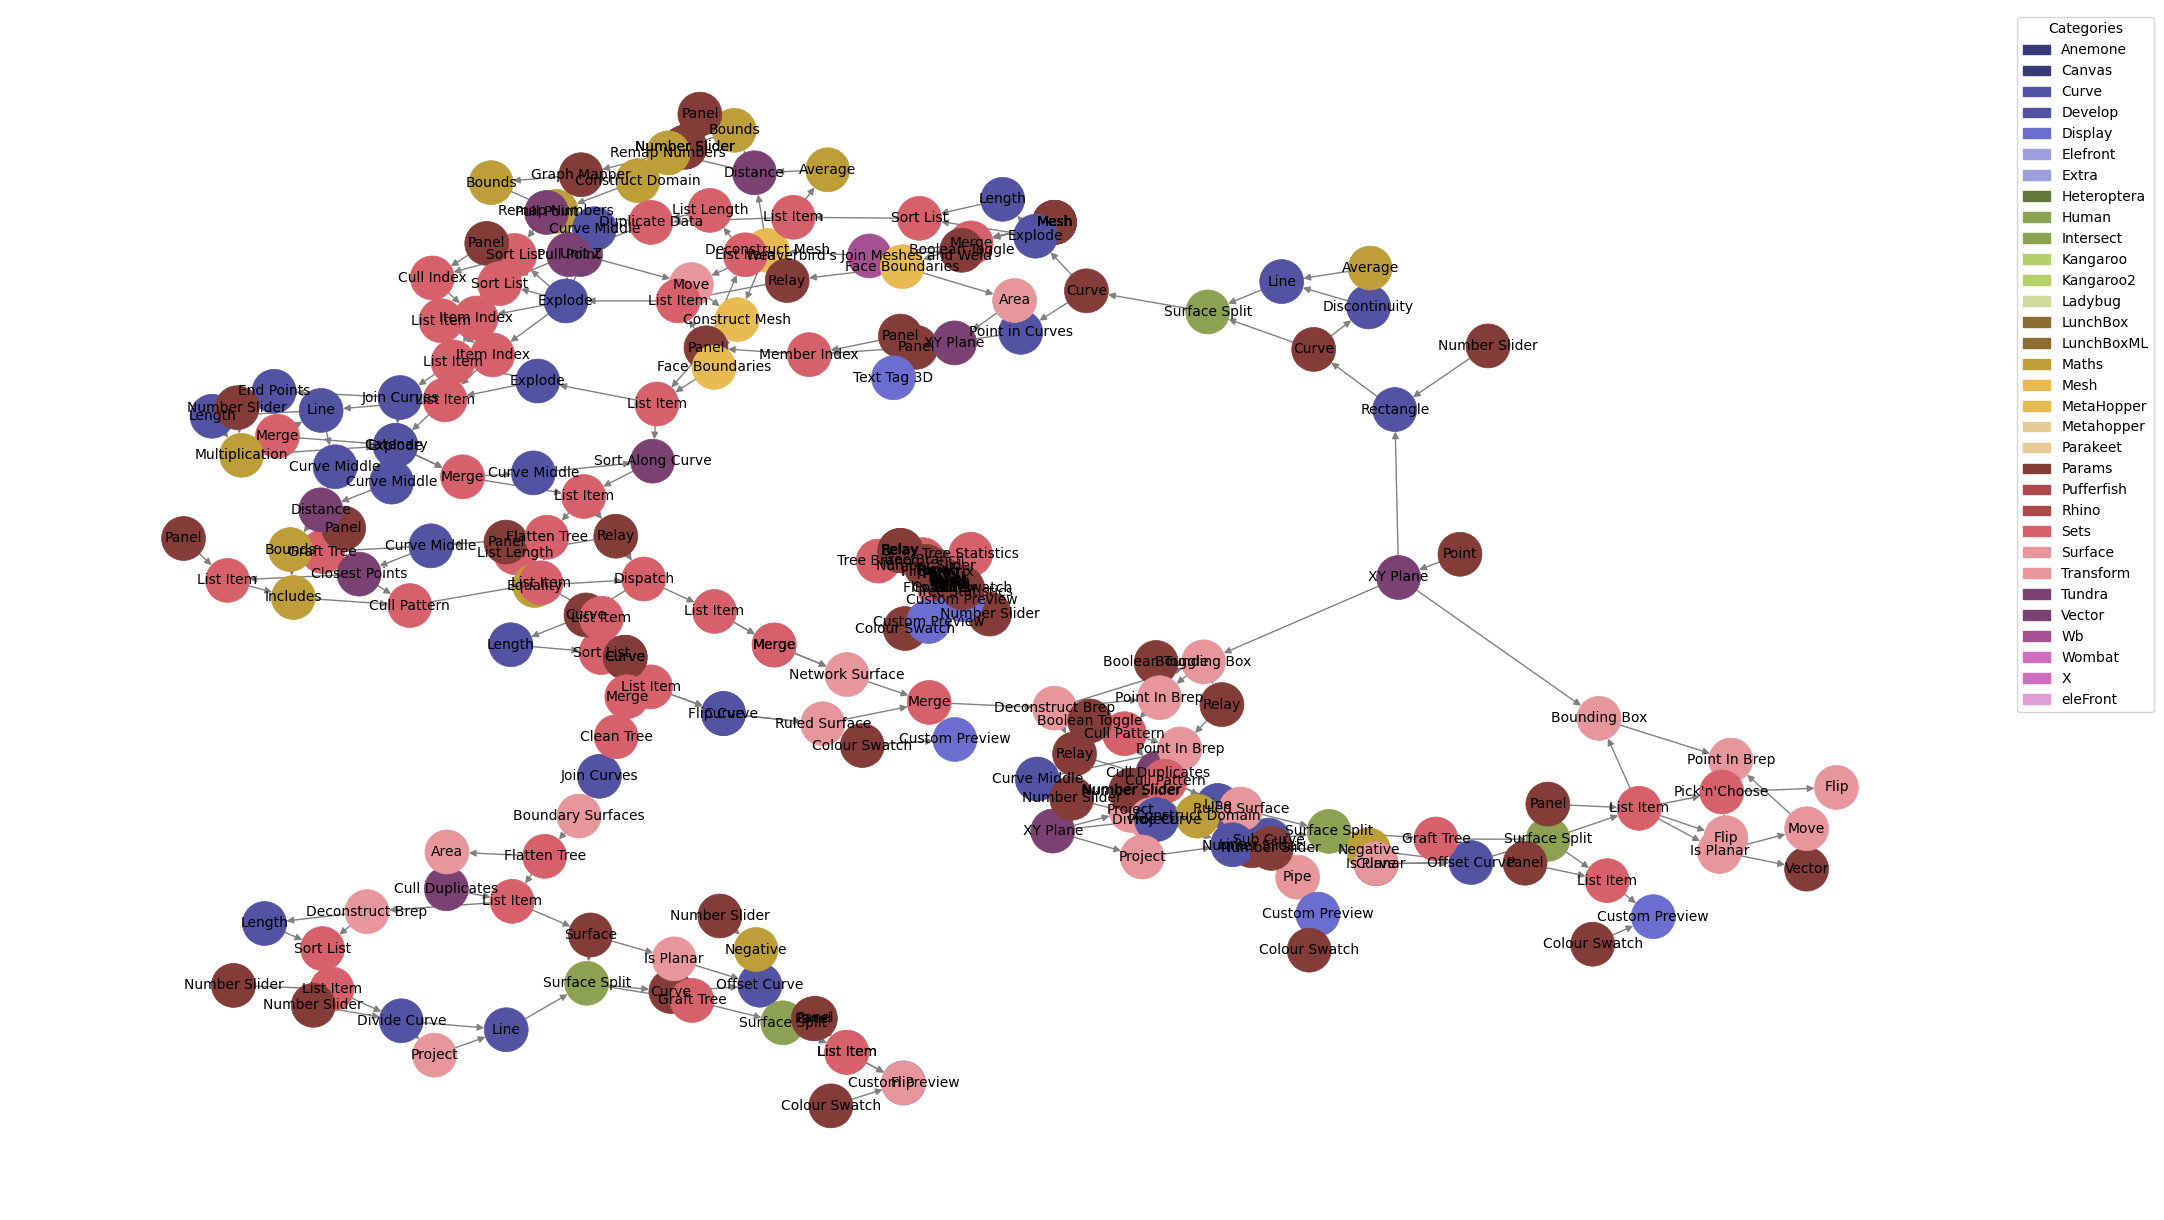

In [39]:
file = r"C:\Users\jossi\Dropbox\Office_Work\Jos\GH_Graph_Learning\TTD\missing comps\missingcomps.gh"
doc = GHProcessor.get_ghdoc(str(file))
canvas = Canvas("canvas", doc, env)
gh_graph = GHGraph_(canvas)
gh_graph.show_graph()



In [ ]:
def process_gh_files(path: Union[str, os.PathLike]):
    # Check if path is a directory or file
    if os.path.isdir(path):
        # Process each .gh file in the directory
        for filename in os.listdir(path):
            if filename.endswith('.gh'):
                file_path = os.path.join(path, filename)
                process_single_file(file_path)
    elif os.path.isfile(path) and path.endswith('.gh'):
        # Process a single .gh file
        process_single_file(path)
    else:
        print(f"The path provided is not a .gh file or a directory containing .gh files: {path}")

def process_single_file(file_path: str):
    # Your existing code to process a single .gh file
    doc = GHProcessor.get_ghdoc(file_path)
    canvas = Canvas("canvas", doc, env)
    print(canvas.graph_id_to_component)
    gh_graph = GHGraph_(canvas)
    gh_graph.show_graph()


process_gh_files(r"C:\Path\To\Your\FileOrDirectory")